## Settingup

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# allow_growth option, which attempts to allocate only as much GPU memory 
# based on runtime allocations: it starts out allocating very little memory, 
# and as Sessions get run and more GPU memory is needed, 
# we extend the GPU memory region needed by the TensorFlow process.
limit_mem()

In [3]:
dpath = os.getcwd() + '/data/'

In [4]:
arr_hr = bcolz.open(dpath+'trn_resized_288.bc')[:]
arr_hr.shape

(19439, 288, 288, 3)

In [14]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [15]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [59]:
parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

## Architecture

In [5]:
shp = arr_hr.shape[1:]

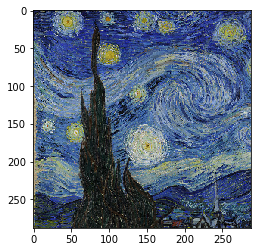

In [9]:
style = Image.open(dpath+'1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')
style = style.resize(np.divide(style.size,3).astype('int32'))
style = np.array(style)[:shp[0], :shp[1], :shp[2]]
plt.imshow(style)

In [35]:
style.shape

(288, 288, 3)

In [10]:
# Upgrading the layers to the keras 2.
# Defining all the blocks required for the super resolution network.

def conv_block(x, filters, size, stride=(2,2), padding='same', act=True):
    x = Conv2D(filters, (size,size), strides=stride, padding=padding)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x) if act else x

def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return merge([x,ip], mode='sum')

def deconv_block(x, filters, size, stride=(2,2), padding='same'):
    x = Conv2DTranspose(filters, (size,size), strides=stride, padding=padding)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

def up_block(x,filters, size, stride=(1,1), padding='same'):
    x = UpSampling2D()(x)
    x = Conv2D(filters,(size,size), strides=stride, padding=padding)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

In [42]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)
    # Legacy support for keras 1    
    def get_output_shape_for(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])
    
    # For keras 2
    def compute_output_shape(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

In [43]:
inp = Input((288,288,3))
ref_model = Model(inp, ReflectionPadding2D((40,10))(inp))
ref_model.compile('adam', 'mse')

In [44]:
p = ref_model.predict(arr_hr[10:11])

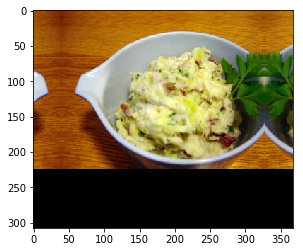

In [45]:
plt.imshow(p[0].astype('uint8'));

In [46]:
def res_crop_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1), 'valid')
    x = conv_block(x,  nf, 3, (1,1), 'valid', False)
    ip = Lambda(lambda x: x[:, 2:-2, 2:-2])(ip)
    return merge([x, ip], mode='sum')

In [47]:
inp=Input(shp)
x=ReflectionPadding2D((40, 40))(inp)
x=conv_block(x, 64, 9, (1,1))
x=conv_block(x, 64, 3)
x=conv_block(x, 64, 3)
for i in range(5): x=res_crop_block(x)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  """
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (9, 9), activation="tanh", padding="same")`
  if __name__ == '__main__':


In [48]:
outp.shape

TensorShape([Dimension(None), Dimension(288), Dimension(288), Dimension(3)])

In [49]:
vgg_inp=Input(shp)
vgg= VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))
for l in vgg.layers: l.trainable=False

In [50]:
def get_outp(m, ln): return m.get_layer(f'block{ln}_conv2').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [2,3,4,5]])

In [51]:
style_targs = [K.variable(o) for o in
               vgg_content.predict(np.expand_dims(style,0))]

In [52]:
[K.eval(K.shape(o)) for o in style_targs]

[array([  1, 144, 144, 128], dtype=int32),
 array([  1,  72,  72, 256], dtype=int32),
 array([  1,  36,  36, 512], dtype=int32),
 array([  1,  18,  18, 512], dtype=int32)]

In [53]:
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

In [54]:
def gram_matrix_b(x):
    x = K.permute_dimensions(x, (0, 3, 1, 2))
    s = K.shape(x)
    feat = K.reshape(x, (s[0], s[1], s[2]*s[3]))
    return K.batch_dot(feat, K.permute_dimensions(feat, (0, 2, 1))
                      ) / K.prod(K.cast(s[1:], K.floatx()))

In [55]:
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

In [56]:
w=[0.1, 0.2, 0.6, 0.1]
def tot_loss(x):
    loss = 0; n = len(style_targs)
    for i in range(n):
        loss += mean_sqr_b(gram_matrix_b(x[i+n]) - gram_matrix_b(style_targs[i])) / 2.
        loss += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return loss

In [57]:
loss = Lambda(tot_loss)(vgg1+vgg2)
m_style = Model([inp, vgg_inp], loss)
targ = np.zeros((arr_hr.shape[0], 1))

In [ ]:
m_style.compile('adam', 'mae')
m_style.fit([arr_hr, arr_hr], targ, 16, 2, **parms)

In [ ]:
K.set_value(m_style.optimizer.lr, 1e-4)
m_style.fit([arr_hr, arr_hr], targ, 16, 1, **parms)

In [62]:
top_model = Model(inp, outp)

In [63]:
p = top_model.predict(arr_hr[:20])

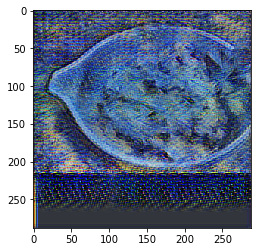

In [66]:
plt.imshow(np.round(p[10]).astype('uint8'));